# An Introduction to Wilson's Uniform Spanning Tree Algorithm

Consider the following problem:

> Let $G$ be a finite, undirected and connected graph. How can we choose a random spanning tree $T$ among all spanning trees of $G$ with equal probability? 

We shall call such a tree $T$ an **uniform spanning tree** (since it's sampled from the uniform measure on all spanning trees of $G$ ), or simply an **UST**.

You might say "that's easy, one just write a program that lists all spanning trees and then use a random integer to choose one". But let's consider the complete graph $K_n$ for example: $K_n$ has $n^{n-2}$ many different spanning trees by [Cayley's formula](https://en.wikipedia.org/wiki/Cayley%27s_formula), for a small integer (say $n=20$) this number is about $2.6\times10^{23}$, I doubt your computer could store such a big chunk of data. For $n=100$ this number is $10^{980}$, far more larger than the number of particles in the universe! (which is estimated to be about $10^{90}$.)

The best algorithm we know so far is the one proposed in Wilson's paper [generating random spanning trees more quickly than the cover time](https://dl.acm.org/citation.cfm?id=237880). It's a random algorithm, which means that some times you may be very lucky to get an UST quickly, or sadly you may wait forever. But it can be proven that this algorithm will terminate in finite steps with probability one (note this does not exclude the possibility of running forever, think about this) and it performs really well in most cases.

The key to understand Wilson's algorithm is the so called [loop erased random walk](https://en.wikipedia.org/wiki/Loop-erased_random_walk), that is, once the random walk visits a vertex that already existed in its path, it immediately erases the loop created by these two successive visits and continues the walk from this vertex. Just watch the gif animation if you don't understand this, it's obvious to see what "loop erased random walk" means from the animation.

The algorithm runs as follows:

> **Wilson's algorithm**: 
> 1. Choose any vertex $v$ as the root, maintain a tree $T$, initially $T=\{v\}$.
>
> 2. For any vertex $z$ that not in $T$, start a loop erased random walk from $z$ until the walk hits $T$, then add the resulting path of the walk to $T$.
>
> 3. repeat step 2 until all vertices of the graph are in $T$. 

The proof of the correctness of this algorithm is a bit tricky and will not be discussed here, you may refer to Wilson's original paper or the book "Probability on Trees and Networks" by Russell Lyons and Yuval Peres. Here I want to emphasis two things that can be deduced from Wilson's proof:

1. One may choose **any vertex** as the root in the beginning.
2. One may choose **any vertex that is not in the tree** to perform the random walk in the main loop.


### Python implementation of the algorithm

Compared with the mathematical complexity behind Wilson's algorithm, the python implementation of it is surprisingly simple: (in the following code the graph $G$ is stored in a dict also denoted by $G$)

In [33]:
import random

def ust(G):
    """Return an UST stored in a dict."""
    root = random.choice(list(G.keys())) # choose any vertex as the root.
    tree = set([root]) # initially the tree contains only the root.
    parent = dict() # a road map that remembers each step in the walk.

    for vertex in G:
        if vertex not in tree:
            # for this vertex we start a loop erased random walk from here until it hits the tree.
            v = vertex
            while v not in tree:
                neighbor = random.choice(G[v])
                parent[v] = neighbor # this is the magic code, loop erasure happens here.
                v = neighbor
                
            # after the while loop the walk has hit the tree, add it's path to the tree.
            v = vertex
            while v not in tree:
                tree.add(v)
                v = parent[v]
    
    # return the tree stored in the dict `parent`.
    return parent

Quite a straight-forward translation of the algorithm, isn't it? You might ask, "wait, you said the algorithm used loop erased random walks to add new vertices to the tree, but I cannot see any code that does the loop-erasure work above?" That's right, indeed the loop erasure happens implicitly in the magic code `parent[v] = neighbor`, since once the walk revisits a vertex $v$, this assignment overwrites its memory of $v$'s successor in its last visit to $v$, so if you travel along the path following the dict `parent` you will not repeat that loop, you just skip it. So even if the actual path may have created many loops before it hits the tree, the "roadmap" `parent` only remembers its "loop erased version" (you may need to think for a while to understan this).

Now let's test our code for an 2d grid graph to see if it gives the right result. Firstly we write a function that returns a 2d grid graph stored in a dict:

In [36]:
def grid_graph(width, height):
    """return a grid graph stored in a dict."""
    def neighbors(v):
        neighborhood = []
        x, y = v
        if x > 0:
            neighborhood.append((x-1, y))
        if y > 0:
            neighborhood.append((x, y-1))
        if x < width - 1:
            neighborhood.append((x+1, y))
        if y < height - 1:
            neighborhood.append((x, y+1))
        return neighborhood
            
    verts = [(x, y) for x in range(width) for y in range(height)]
    return {v: neighbors(v) for v in verts}

Then we can sample an UST of a grid graph (say 48x36) as follows:

In [43]:
width, height = 48, 36
G = grid_graph(width, height)
tree = ust(G)

Finally we use matplotlib to display the tree, it's only a few lines more work!

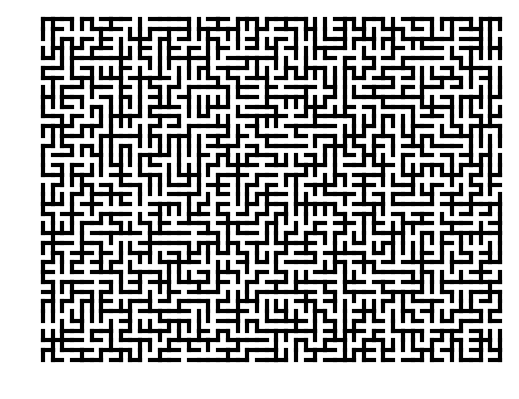

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4.8, 3.6), dpi=100)
ax = fig.add_axes([0, 0, 1, 1], aspect=1)
ax.axis('off')
ax.axis([-1, width, -1, height])

for key, item in tree.items():
    a, b = key
    x, y = item
    ax.plot([a, x], [b, y], 'k-', lw=3)

plt.show()